In [12]:
import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from tsfresh.feature_extraction import MinimalFCParameters
from tsfresh import extract_features
from scipy.stats import pearsonr
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
ds = datasets.load_dataset("autogluon/chronos_datasets", "m4_weekly", split="train")
ds.set_format("numpy")  # sequences returned as numpy arrays

Using the latest cached version of the dataset since autogluon/chronos_datasets couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'm4_weekly' at /home/flostyle/.cache/huggingface/datasets/autogluon___chronos_datasets/m4_weekly/0.0.0/e2f1aab370667e374be4b2150fa95240a66cb0d6 (last modified on Sun Dec 15 10:45:30 2024).


In [4]:
ds

Dataset({
    features: ['id', 'timestamp', 'target', 'category'],
    num_rows: 359
})

In [5]:
df = ds.to_pandas()

df.head()

,id,timestamp,target,category
0,T000000,"[1975-08-03T12:00:00.000, 1975-08-10T12:00:00....","[1089.2, 1078.91, 1079.88, 1063.58, 1060.61, 1...",Other
1,T000001,"[1984-04-01T12:00:00.000, 1984-04-08T12:00:00....","[195.928, 194.796, 192.71, 190.288, 188.77, 18...",Other
2,T000002,"[1975-06-01T12:00:00.000, 1975-06-08T12:00:00....","[258.7, 259.8, 260.2, 260.8, 261.1, 263.1, 264...",Other
3,T000003,"[1967-07-02T12:00:00.000, 1967-07-09T12:00:00....","[3460.0, 3340.0, 2770.0, 2520.0, 2740.0, 2760....",Other
4,T000004,"[1986-08-03T12:00:00.000, 1986-08-10T12:00:00....","[4696.0, 4765.0, 4144.0, 3945.0, 4733.0, 4330....",Other


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359 entries, 0 to 358
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         359 non-null    object
 1   timestamp  359 non-null    object
 2   target     359 non-null    object
 3   category   359 non-null    object
dtypes: object(4)
memory usage: 11.3+ KB


In [7]:
df = df.drop('category', axis=1)
df

,id,timestamp,target
0,T000000,"[1975-08-03T12:00:00.000, 1975-08-10T12:00:00....","[1089.2, 1078.91, 1079.88, 1063.58, 1060.61, 1..."
1,T000001,"[1984-04-01T12:00:00.000, 1984-04-08T12:00:00....","[195.928, 194.796, 192.71, 190.288, 188.77, 18..."
2,T000002,"[1975-06-01T12:00:00.000, 1975-06-08T12:00:00....","[258.7, 259.8, 260.2, 260.8, 261.1, 263.1, 264..."
3,T000003,"[1967-07-02T12:00:00.000, 1967-07-09T12:00:00....","[3460.0, 3340.0, 2770.0, 2520.0, 2740.0, 2760...."
4,T000004,"[1986-08-03T12:00:00.000, 1986-08-10T12:00:00....","[4696.0, 4765.0, 4144.0, 3945.0, 4733.0, 4330...."
...,...,...,...
354,T000354,"[2016-01-03T12:00:00.000, 2016-01-10T12:00:00....","[4798.0, 5192.0, 4194.0, 4217.0, 3926.0, 3987...."
355,T000355,"[2016-01-03T12:00:00.000, 2016-01-10T12:00:00....","[4923.0, 6382.0, 4387.0, 4979.0, 4660.0, 4437...."
356,T000356,"[2016-01-03T12:00:00.000, 2016-01-10T12:00:00....","[4401.0, 4955.0, 3680.0, 4214.0, 4139.0, 3384...."
357,T000357,"[2016-01-03T12:00:00.000, 2016-01-10T12:00:00....","[5977.0, 7770.0, 5843.0, 6169.0, 5990.0, 5537...."


In [8]:
df['id'] = df['id'].str.replace('T','').astype(int)

df

,id,timestamp,target
0,0,"[1975-08-03T12:00:00.000, 1975-08-10T12:00:00....","[1089.2, 1078.91, 1079.88, 1063.58, 1060.61, 1..."
1,1,"[1984-04-01T12:00:00.000, 1984-04-08T12:00:00....","[195.928, 194.796, 192.71, 190.288, 188.77, 18..."
2,2,"[1975-06-01T12:00:00.000, 1975-06-08T12:00:00....","[258.7, 259.8, 260.2, 260.8, 261.1, 263.1, 264..."
3,3,"[1967-07-02T12:00:00.000, 1967-07-09T12:00:00....","[3460.0, 3340.0, 2770.0, 2520.0, 2740.0, 2760...."
4,4,"[1986-08-03T12:00:00.000, 1986-08-10T12:00:00....","[4696.0, 4765.0, 4144.0, 3945.0, 4733.0, 4330...."
...,...,...,...
354,354,"[2016-01-03T12:00:00.000, 2016-01-10T12:00:00....","[4798.0, 5192.0, 4194.0, 4217.0, 3926.0, 3987...."
355,355,"[2016-01-03T12:00:00.000, 2016-01-10T12:00:00....","[4923.0, 6382.0, 4387.0, 4979.0, 4660.0, 4437...."
356,356,"[2016-01-03T12:00:00.000, 2016-01-10T12:00:00....","[4401.0, 4955.0, 3680.0, 4214.0, 4139.0, 3384...."
357,357,"[2016-01-03T12:00:00.000, 2016-01-10T12:00:00....","[5977.0, 7770.0, 5843.0, 6169.0, 5990.0, 5537...."


In [9]:
# Convert timestamps to datetime objects
df['timestamp'] = df['timestamp'].apply(lambda x: pd.to_datetime(x))

print(df['timestamp'].dtype)

object


# EDA

In [9]:
# measuring each time series' length
series_lengths = []
for idx, row in df.iterrows():
    series_length = len(row['timestamp'])
    series_lengths.append((row['id'], series_length))

series_lengths_sorted = sorted(series_lengths, key = lambda x:x[1], reverse = True)

# Print the sorted list of series lengths
for id_, length in series_lengths_sorted:
    print(f"ID: {id_}, Series Length: {length}")

ID: 3, Series Length: 2610
ID: 223, Series Length: 2609
ID: 59, Series Length: 2297
ID: 87, Series Length: 2296
ID: 90, Series Length: 2296
ID: 91, Series Length: 2296
ID: 95, Series Length: 2296
ID: 96, Series Length: 2296
ID: 97, Series Length: 2296
ID: 98, Series Length: 2296
ID: 99, Series Length: 2296
ID: 101, Series Length: 2296
ID: 102, Series Length: 2296
ID: 104, Series Length: 2296
ID: 106, Series Length: 2296
ID: 107, Series Length: 2296
ID: 108, Series Length: 2296
ID: 111, Series Length: 2296
ID: 114, Series Length: 2296
ID: 115, Series Length: 2296
ID: 120, Series Length: 2296
ID: 121, Series Length: 2296
ID: 122, Series Length: 2296
ID: 123, Series Length: 2296
ID: 124, Series Length: 2296
ID: 126, Series Length: 2296
ID: 127, Series Length: 2296
ID: 129, Series Length: 2296
ID: 131, Series Length: 2296
ID: 132, Series Length: 2296
ID: 133, Series Length: 2296
ID: 171, Series Length: 2296
ID: 0, Series Length: 2192
ID: 61, Series Length: 2192
ID: 62, Series Length: 2192


## Seasonal decomposition

<Figure size 1200x600 with 0 Axes>

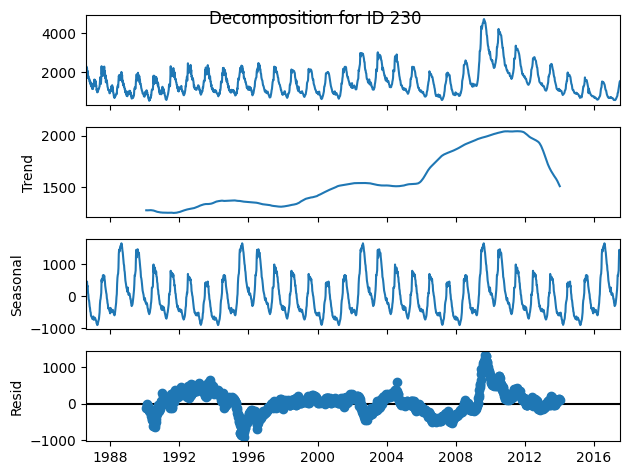

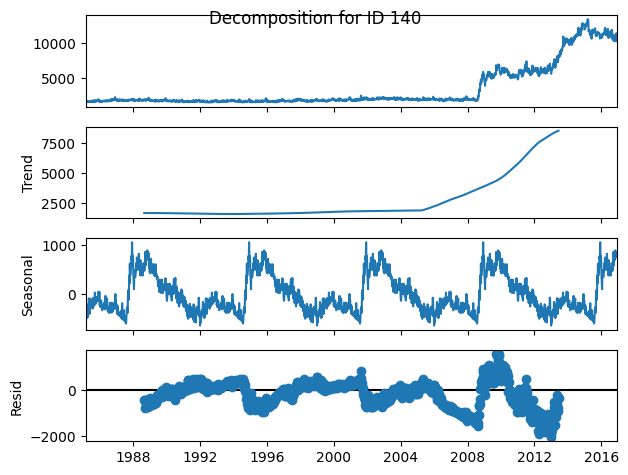

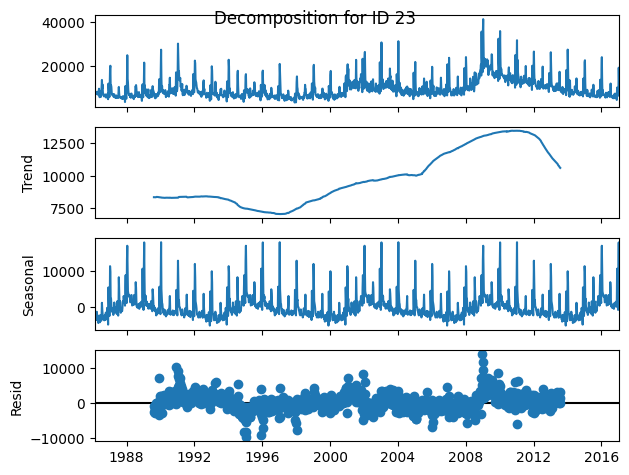

In [10]:
#select first three rows
rows_to_analyze = df.iloc[[230, 140, 23]]

# For each row, plot the target values against the timestamps
plt.figure(figsize=(12, 6))
for index, row in rows_to_analyze.iterrows():
    target = pd.Series(row['target'], index=row['timestamp'])
    # Decompose the time series using seasonal decomposition
    result = seasonal_decompose(target, model='additive', period=365)  # Adjust period based on your data
    
    # Plot the decomposed components
    result.plot()
    plt.suptitle(f"Decomposition for ID {row['id']}")
    plt.show()

## ADF test

In [86]:
def adf_test(df):
    results = []
    for index, row in df.iterrows():
        targets = pd.Series(row['target'])
        result = adfuller(targets)
        test_stat = result[0]
        pvalue = result[1]
        stationary = pvalue<0.5
        
        results.append({'id': row['id'], 'test_stat': test_stat, 'pvalue': pvalue, 'stationary': stationary})

    return pd.DataFrame(results)

stationarity = adf_test(df)

print(stationarity)

# Summary of stationary vs non-stationary series
stationary_counts = stationarity['stationary'].value_counts()
print("\nSummary of Stationary Time Series:")
print(stationary_counts)

      id  test_stat        pvalue  stationary
0      0   0.062403  9.633984e-01       False
1      1   0.285315  9.766606e-01       False
2      2   4.465878  1.000000e+00       False
3      3  -7.064916  5.110021e-10        True
4      4  -3.702289  4.081067e-03        True
..   ...        ...           ...         ...
354  354  -1.544541  5.113738e-01       False
355  355  -3.090631  2.725436e-02        True
356  356  -2.571113  9.911587e-02        True
357  357  -3.041773  3.117322e-02        True
358  358  -2.906340  4.461574e-02        True

[359 rows x 4 columns]

Summary of Stationary Time Series:
stationary
True     198
False    161
Name: count, dtype: int64


## PSI

In [10]:
df_flat = df.explode(column=['timestamp', 'target']).reset_index(drop=True)

df_flat

,id,timestamp,target
0,0,1975-08-03 12:00:00,1089.2
1,0,1975-08-10 12:00:00,1078.91
2,0,1975-08-17 12:00:00,1079.88
3,0,1975-08-24 12:00:00,1063.58
4,0,1975-08-31 12:00:00,1060.61
...,...,...,...
371574,358,2017-09-10 12:00:00,3386.0
371575,358,2017-09-17 12:00:00,3627.0
371576,358,2017-09-24 12:00:00,3299.0
371577,358,2017-10-01 12:00:00,3743.0


In [12]:
# Split for each ID individually
train_data = []
test_data = []
oos_data = []

for id_ in df_flat["id"].unique():
    id_data = df_flat[df_flat["id"] == id_]
    
    # Calculate split indices
    train_end = int(len(id_data) * 0.6)
    test_end = train_end + int(len(id_data) * 0.2)
    
    # Split data
    train_data.append(id_data.iloc[:train_end])
    test_data.append(id_data.iloc[train_end:test_end])
    oos_data.append(id_data.iloc[test_end:])

# Concatenate all splits into final datasets
train_df_flat = pd.concat(train_data)
test_df_flat = pd.concat(test_data)
oos_df_flat = pd.concat(oos_data)

# Reset index
train_df_flat.reset_index(drop=True, inplace=True)
test_df_flat.reset_index(drop=True, inplace=True)
oos_df_flat.reset_index(drop=True, inplace=True)

print("Train Set:")
print(train_df_flat)
print("\nTest Set:")
print(test_df_flat)
print("\nOOS Set:")
print(oos_df_flat)

Train Set:
         id           timestamp   target
0         0 1975-08-03 12:00:00   1089.2
1         0 1975-08-10 12:00:00  1078.91
2         0 1975-08-17 12:00:00  1079.88
3         0 1975-08-24 12:00:00  1063.58
4         0 1975-08-31 12:00:00  1060.61
...     ...                 ...      ...
222801  358 2016-12-18 12:00:00   5120.0
222802  358 2016-12-25 12:00:00   4242.0
222803  358 2017-01-01 12:00:00   3688.0
222804  358 2017-01-08 12:00:00   3151.0
222805  358 2017-01-15 12:00:00   4191.0

[222806 rows x 3 columns]

Test Set:
        id           timestamp   target
0        0 2000-10-15 12:00:00  5768.94
1        0 2000-10-22 12:00:00  5774.51
2        0 2000-10-29 12:00:00  5774.51
3        0 2000-11-05 12:00:00  5786.19
4        0 2000-11-12 12:00:00  5786.19
...    ...                 ...      ...
74172  358 2017-04-23 12:00:00   2625.0
74173  358 2017-04-30 12:00:00   3081.0
74174  358 2017-05-07 12:00:00   3255.0
74175  358 2017-05-14 12:00:00   3243.0
74176  358 2017-05-

In [13]:
results = []

for id_ in train_df_flat["id"].unique():
    # Extract train and test targets for this id
    train_target = train_df_flat[train_df_flat["id"] == id_]["target"]
    test_target = test_df_flat[test_df_flat["id"] == id_]["target"]
    
    # Calculate PSI
    """Calculate PSI for a feature."""
    expected_percents, bins = np.histogram(train_target, bins=10)
    actual_percents, _ = np.histogram(test_target, bins=10)

    expected_percents = expected_percents / len(train_target)
    actual_percents = actual_percents / len(test_target)

    psi = np.sum((expected_percents - actual_percents) * np.log(expected_percents / actual_percents))
    
    # Calculate Correlation
    train_target_numeric = pd.to_numeric(train_target, errors='coerce').dropna()
    test_target_numeric = pd.to_numeric(test_target, errors='coerce').dropna()
    corr, _ = pearsonr(train_target_numeric[:len(test_target_numeric)], test_target_numeric)
    
    # Store results
    results.append({"id": id_, "PSI": psi, "Correlation": corr})

# Display results
for result in results:
    print(f"ID: {result['id']}, PSI: {result['PSI']}, Correlation: {result['Correlation']}")


/tmp/ipykernel_1280/3342552100.py:16: RuntimeWarning: divide by zero encountered in log
  psi = np.sum((expected_percents - actual_percents) * np.log(expected_percents / actual_percents))
/tmp/ipykernel_1280/3342552100.py:16: RuntimeWarning: divide by zero encountered in divide
  psi = np.sum((expected_percents - actual_percents) * np.log(expected_percents / actual_percents))
/tmp/ipykernel_1280/3342552100.py:16: RuntimeWarning: invalid value encountered in divide
  psi = np.sum((expected_percents - actual_percents) * np.log(expected_percents / actual_percents))


ID: 0, PSI: 0.9803546210696965, Correlation: 0.9780985492551678
ID: 1, PSI: 2.6449063232767753, Correlation: 0.7371601545067914
ID: 2, PSI: inf, Correlation: 0.8866262715813117
ID: 3, PSI: 0.07536866107595584, Correlation: 0.35444886348240595
ID: 4, PSI: inf, Correlation: -0.0025115987611959815
ID: 5, PSI: 0.4794173285076857, Correlation: 0.30543849991383853
ID: 6, PSI: inf, Correlation: -0.004805817491073483
ID: 7, PSI: inf, Correlation: -0.05343038369791747
ID: 8, PSI: inf, Correlation: -0.017270893787163902
ID: 9, PSI: inf, Correlation: 0.15844348021088117
ID: 10, PSI: 0.5905203129035822, Correlation: 0.3847916002806758
ID: 11, PSI: 0.4479269170562561, Correlation: -0.054845002163172174
ID: 12, PSI: 1.7992738817243625, Correlation: 0.8758904225565474
ID: 13, PSI: inf, Correlation: 0.8373080201133583
ID: 14, PSI: inf, Correlation: 0.33307431911810303
ID: 15, PSI: inf, Correlation: 0.33307431911810303
ID: 16, PSI: 2.3443395987874496, Correlation: 0.1207286402915819
ID: 17, PSI: 4.0376

# Feature generation

In [10]:
# tsfresh: Generate features using MinimalFCParameters
extracted_features = extract_features(
    df_flat,
    column_id="id",
    column_sort="timestamp",
    default_fc_parameters=MinimalFCParameters(),
    disable_progressbar=True
)

# Merge extracted features back to the main dataframe
df_features = df_flat.merge(extracted_features, left_on="id", right_index=True, how="left")

df_features

,id,timestamp,target,target__sum_values,target__median,target__mean,target__length,target__standard_deviation,target__variance,target__root_mean_square,target__maximum,target__absolute_maximum,target__minimum
0,0,1975-08-03 12:00:00,1089.2,19606106.67,4392.895,8944.391729,2192.0,10999.095750,1.209801e+08,14176.820896,41304.72,41304.72,1049.32
1,0,1975-08-10 12:00:00,1078.91,19606106.67,4392.895,8944.391729,2192.0,10999.095750,1.209801e+08,14176.820896,41304.72,41304.72,1049.32
2,0,1975-08-17 12:00:00,1079.88,19606106.67,4392.895,8944.391729,2192.0,10999.095750,1.209801e+08,14176.820896,41304.72,41304.72,1049.32
3,0,1975-08-24 12:00:00,1063.58,19606106.67,4392.895,8944.391729,2192.0,10999.095750,1.209801e+08,14176.820896,41304.72,41304.72,1049.32
4,0,1975-08-31 12:00:00,1060.61,19606106.67,4392.895,8944.391729,2192.0,10999.095750,1.209801e+08,14176.820896,41304.72,41304.72,1049.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...
371574,358,2017-09-10 12:00:00,3386.0,321909.00,3299.000,3461.387097,93.0,666.156962,4.437651e+05,3524.906485,5237.00,5237.00,2221.00
371575,358,2017-09-17 12:00:00,3627.0,321909.00,3299.000,3461.387097,93.0,666.156962,4.437651e+05,3524.906485,5237.00,5237.00,2221.00
371576,358,2017-09-24 12:00:00,3299.0,321909.00,3299.000,3461.387097,93.0,666.156962,4.437651e+05,3524.906485,5237.00,5237.00,2221.00
371577,358,2017-10-01 12:00:00,3743.0,321909.00,3299.000,3461.387097,93.0,666.156962,4.437651e+05,3524.906485,5237.00,5237.00,2221.00


In [13]:
df_features = df_flat

# Temporal Features
df_features["week_of_year"] = df_features["timestamp"].dt.isocalendar().week
df_features["month"] = df_features["timestamp"].dt.month

# Cyclic Features for Week of Year and Month
df_features["week_of_year_sin"] = np.sin(2 * np.pi * df_features["week_of_year"] / 52)
df_features["week_of_year_cos"] = np.cos(2 * np.pi * df_features["week_of_year"] / 52)
df_features["month_sin"] = np.sin(2 * np.pi * df_features["month"] / 12)
df_features["month_cos"] = np.cos(2 * np.pi * df_features["month"] / 12)

df_features

,id,timestamp,target,week_of_year,month,week_of_year_sin,week_of_year_cos,month_sin,month_cos
0,0,1975-08-03 12:00:00,1089.2,31,8,-0.568065,-0.822984,-0.866025,-5.000000e-01
1,0,1975-08-10 12:00:00,1078.91,32,8,-0.663123,-0.748511,-0.866025,-5.000000e-01
2,0,1975-08-17 12:00:00,1079.88,33,8,-0.748511,-0.663123,-0.866025,-5.000000e-01
3,0,1975-08-24 12:00:00,1063.58,34,8,-0.822984,-0.568065,-0.866025,-5.000000e-01
4,0,1975-08-31 12:00:00,1060.61,35,8,-0.885456,-0.464723,-0.866025,-5.000000e-01
...,...,...,...,...,...,...,...,...,...
371574,358,2017-09-10 12:00:00,3386.0,36,9,-0.935016,-0.354605,-1.000000,-1.836970e-16
371575,358,2017-09-17 12:00:00,3627.0,37,9,-0.970942,-0.239316,-1.000000,-1.836970e-16
371576,358,2017-09-24 12:00:00,3299.0,38,9,-0.992709,-0.120537,-1.000000,-1.836970e-16
371577,358,2017-10-01 12:00:00,3743.0,39,10,-1.0,-0.0,-0.866025,5.000000e-01


In [14]:
# Lagged Features
for lag in [1, 2, 4, 8, 12, 26, 52]:  # Lags for weekly data
    #df_features[f"lag_{lag}"] = df_features.groupby("id")["target"].shift(lag).fillna(0).astype(float)
    df_features[f"lag_{lag}"] = df_features.groupby("id")["target"].shift(lag).astype(float)

# Rolling Features (Monthly 4, Quarterly 12, Yearly 52)
df_features["rolling_mean_4"] = (
    df_features.groupby("id")["target"].rolling(window=4).mean().reset_index(level=0, drop=True)
)
df_features["rolling_std_4"] = (
    df_features.groupby("id")["target"].rolling(window=4).std().reset_index(level=0, drop=True)
)
df_features["rolling_mean_12"] = (
    df_features.groupby("id")["target"].rolling(window=12).mean().reset_index(level=0, drop=True)
)
df_features["rolling_std_12"] = (
    df_features.groupby("id")["target"].rolling(window=12).std().reset_index(level=0, drop=True)
)
df_features["rolling_mean_52"] = (
    df_features.groupby("id")["target"].rolling(window=52).mean().reset_index(level=0, drop=True)
)
df_features["rolling_std_52"] = (
    df_features.groupby("id")["target"].rolling(window=52).std().reset_index(level=0, drop=True)
)

df_features

,id,timestamp,target,week_of_year,month,week_of_year_sin,week_of_year_cos,month_sin,month_cos,lag_1,...,lag_8,lag_12,lag_26,lag_52,rolling_mean_4,rolling_std_4,rolling_mean_12,rolling_std_12,rolling_mean_52,rolling_std_52
0,0,1975-08-03 12:00:00,1089.2,31,8,-0.568065,-0.822984,-0.866025,-5.000000e-01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1975-08-10 12:00:00,1078.91,32,8,-0.663123,-0.748511,-0.866025,-5.000000e-01,1089.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1975-08-17 12:00:00,1079.88,33,8,-0.748511,-0.663123,-0.866025,-5.000000e-01,1078.91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,1975-08-24 12:00:00,1063.58,34,8,-0.822984,-0.568065,-0.866025,-5.000000e-01,1079.88,...,NaN,NaN,NaN,NaN,1077.8925,10.609629,NaN,NaN,NaN,NaN
4,0,1975-08-31 12:00:00,1060.61,35,8,-0.885456,-0.464723,-0.866025,-5.000000e-01,1063.58,...,NaN,NaN,NaN,NaN,1070.7450,10.069275,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371574,358,2017-09-10 12:00:00,3386.0,36,9,-0.935016,-0.354605,-1.000000,-1.836970e-16,4213.00,...,4458.0,3478.0,2774.0,3166.0,3422.0000,654.312362,3992.083333,750.805441,3496.250000,684.000942
371575,358,2017-09-17 12:00:00,3627.0,37,9,-0.970942,-0.239316,-1.000000,-1.836970e-16,3386.00,...,5098.0,3545.0,2682.0,2774.0,3675.5000,371.873186,3998.916667,746.728557,3512.653846,676.527752
371576,358,2017-09-24 12:00:00,3299.0,38,9,-0.992709,-0.120537,-1.000000,-1.836970e-16,3627.00,...,4518.0,3242.0,2297.0,2932.0,3631.2500,411.901586,4003.666667,741.639993,3519.711538,672.252268
371577,358,2017-10-01 12:00:00,3743.0,39,10,-1.0,-0.0,-0.866025,5.000000e-01,3299.00,...,4973.0,4410.0,2756.0,3218.0,3513.7500,206.412815,3948.083333,733.366764,3529.807692,671.574183


# 

## Feature importance

In [94]:
feature_importance_results = {}

for id_ in df_features["id"].unique():
    id_data = df_features[df_features["id"] == id_]
    # Split features and target
    X, y = id_data.drop(columns=["target", "timestamp", "id"]), id_data["target"]


    # Train the XGBoost model
    model = XGBRegressor(random_state=42)
    model.fit(X, y)

    # Get feature importance
    importance = model.feature_importances_
    feature_importance_results[id_] = dict(zip(X.columns, importance))

print(feature_importance_results)

{0: {'week_of_year': 8.752887e-06, 'month': 6.3209677e-06, 'week_of_year_sin': 1.5221763e-05, 'week_of_year_cos': 1.0989724e-05, 'month_sin': 1.0062499e-05, 'month_cos': 1.0989927e-05, 'lag_1': 0.053096984, 'lag_2': 0.03883897, 'lag_4': 0.00035293453, 'lag_8': 0.022905517, 'lag_12': 0.00016911655, 'lag_26': 0.08935213, 'lag_52': 0.0020213325, 'rolling_mean_4': 0.68647224, 'rolling_std_4': 2.3687762e-05, 'rolling_mean_12': 0.022152085, 'rolling_std_12': 0.00022584945, 'rolling_mean_52': 0.08430882, 'rolling_std_52': 1.8028146e-05}, 1: {'week_of_year': 2.1046999e-05, 'month': 1.0149738e-05, 'week_of_year_sin': 4.2099244e-05, 'week_of_year_cos': 9.033343e-06, 'month_sin': 1.7543147e-05, 'month_cos': 1.22413e-05, 'lag_1': 0.12328664, 'lag_2': 0.00018438757, 'lag_4': 0.025737802, 'lag_8': 0.0028296192, 'lag_12': 5.18466e-05, 'lag_26': 2.9759462e-05, 'lag_52': 0.3625598, 'rolling_mean_4': 0.16857222, 'rolling_std_4': 9.260998e-05, 'rolling_mean_12': 0.0028224522, 'rolling_std_12': 1.98785e-0

In [95]:
# Convert feature importance results into a DataFrame
importance_data = []
for id_, features in feature_importance_results.items():
    for feature, importance in features.items():
        importance_data.append({"id": id_, "feature": feature, "importance": importance})

# Create the DataFrame
importance_df = pd.DataFrame(importance_data)

# Sort the DataFrame by id and descending importance
importance_df = importance_df.sort_values(by=["id", "importance"], ascending=[True, False])

# Display the DataFrame
print(importance_df)

       id          feature    importance
13      0   rolling_mean_4  6.864722e-01
11      0           lag_26  8.935213e-02
17      0  rolling_mean_52  8.430882e-02
6       0            lag_1  5.309698e-02
7       0            lag_2  3.883897e-02
...   ...              ...           ...
6807  358        month_cos  2.320496e-03
6820  358   rolling_std_52  4.493276e-04
6803  358            month  2.379248e-04
6819  358  rolling_mean_52  1.257804e-04
6806  358        month_sin  6.373364e-07

[6821 rows x 3 columns]


In [96]:
# Get the top 2 most important features for each id
top_2_features = importance_df.groupby("id").head(2)

# Display the top 5 features for each id
print(top_2_features)


       id          feature  importance
13      0   rolling_mean_4    0.686472
11      0           lag_26    0.089352
31      1           lag_52    0.362560
36      1  rolling_mean_52    0.304695
50      2           lag_52    0.517449
...   ...              ...         ...
6768  356        month_sin    0.132360
6796  357   rolling_mean_4    0.632401
6797  357    rolling_std_4    0.085124
6815  358   rolling_mean_4    0.663967
6816  358    rolling_std_4    0.109228

[718 rows x 3 columns]


# Modeling for each time series individually

## Random grid search 

In [ ]:
# Initialize results storage
random_search_results = {}

# Hyperparameter space for RandomizedSearchCV
param_grid = {
    "n_estimators": (50, 200),
    "learning_rate": (0.01, 0.3),
    "max_depth": (4, 6),
    #"subsample": (0.7, 1.0),
    #"colsample_bytree": (0.7, 1.0),
}

# Perform RandomizedSearchCV for each time series
for id_ in df_features["id"].unique():
    id_data = df_features[df_features["id"] == id_]

    # Define features and target
    X = id_data.drop(columns=["id", "timestamp", "target"])
    y = id_data["target"]
    
    # Split into train and test sets
    split_index = int(len(X) * 0.9)  # 90% train, 10% test
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=3)

    # Initialize model
    model = XGBRegressor(random_state=42)

    # Randomized Search with TimeSeriesSplit
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=20,
        scoring="neg_mean_absolute_percentage_error",
        cv=tscv,
        verbose=1,
        random_state=42,
        n_jobs=-1,
    )

    # Fit RandomizedSearchCV
    random_search.fit(X_train, y_train)

    # Store the results
    best_params = random_search.best_params_
    best_score = -random_search.best_score_  # Convert back from negative MAPE
    random_search_results[id_] = {
        "best_params": best_params,
        "best_score": best_score,
    }

In [15]:
# Display Results
for id_, result in random_search_results.items():
    print(f"ID: {id_}")
    print(f"Best Parameters: {result['best_params']}")
    print(f"Best Score (MAPE): {result['best_score']}\n")

ID: 0
Best Parameters: {'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.3}
Best Score (MAPE): 0.2879402713295268

ID: 1
Best Parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.3}
Best Score (MAPE): 0.2965511868320388

ID: 2
Best Parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.3}
Best Score (MAPE): 0.2172477054825578

ID: 3
Best Parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.3}
Best Score (MAPE): 0.05067401720023016

ID: 4
Best Parameters: {'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.3}
Best Score (MAPE): 0.133067531417521

ID: 5
Best Parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.3}
Best Score (MAPE): 0.13532458584512128

ID: 6
Best Parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.3}
Best Score (MAPE): 0.13044861994127785

ID: 7
Best Parameters: {'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.3}
Best Score (MAPE): 0.11945564942290864

ID: 8
Best Parameters: {

## Making predictions using random gird search

In [17]:
from sklearn.metrics import mean_absolute_percentage_error

# Initialize results storage for test evaluation
test_results = {}

# Iterate through each time series again
for id_ in df_features["id"].unique():
    id_data = df_features[df_features["id"] == id_]

    # Define features and target
    X = id_data.drop(columns=["id", "timestamp", "target"])
    y = id_data["target"]

    # Split into train and test sets
    split_index = int(len(X) * 0.9)  # 90% train, 10% test
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # Best estimator from RandomizedSearchCV
    best_model = random_search_results[id_]["best_params"]

    # Initialize model with best hyperparameters
    model = XGBRegressor(**best_model, random_state=42)

    # Fit the model on the entire training set
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Evaluate on the test set
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Store test results
    test_results[id_] = {
        "mape": mape,
    }

# Print test results
for id_, result in test_results.items():
    print(f"ID: {id_}, MAPE: {result['mape']:.4f}")

ID: 0, MAPE: 0.2641
ID: 1, MAPE: 0.1271
ID: 2, MAPE: 0.1073
ID: 3, MAPE: 0.0384
ID: 4, MAPE: 0.1926
ID: 5, MAPE: 0.1025
ID: 6, MAPE: 0.3504
ID: 7, MAPE: 0.1190
ID: 8, MAPE: 0.0583
ID: 9, MAPE: 0.0289
ID: 10, MAPE: 0.4382
ID: 11, MAPE: 0.0014
ID: 12, MAPE: 0.0806
ID: 13, MAPE: 0.0839
ID: 14, MAPE: 0.1409
ID: 15, MAPE: 0.1121
ID: 16, MAPE: 0.0516
ID: 17, MAPE: 0.0834
ID: 18, MAPE: 0.3034
ID: 19, MAPE: 0.0539
ID: 20, MAPE: 0.1370
ID: 21, MAPE: 0.0847
ID: 22, MAPE: 0.0600
ID: 23, MAPE: 0.0975
ID: 24, MAPE: 0.1184
ID: 25, MAPE: 0.1029
ID: 26, MAPE: 0.1336
ID: 27, MAPE: 0.1424
ID: 28, MAPE: 0.1474
ID: 29, MAPE: 0.0661
ID: 30, MAPE: 0.1277
ID: 31, MAPE: 0.0927
ID: 32, MAPE: 0.0571
ID: 33, MAPE: 0.0590
ID: 34, MAPE: 0.0766
ID: 35, MAPE: 0.1665
ID: 36, MAPE: 0.0206
ID: 37, MAPE: 0.0159
ID: 38, MAPE: 0.0109
ID: 39, MAPE: 0.0092
ID: 40, MAPE: 0.0111
ID: 41, MAPE: 0.0092
ID: 42, MAPE: 0.0121
ID: 43, MAPE: 0.0095
ID: 44, MAPE: 0.0407
ID: 45, MAPE: 0.0223
ID: 46, MAPE: 0.0396
ID: 47, MAPE: 0.0381
ID

## Simple XGboost without random grid search

In [ ]:
# Initialize an empty dictionary to store results
results = {}

# Iterate over each time series (unique id)
for id_ in df_features["id"].unique():
    # Filter data for the current id
    id_data = df_features[df_features["id"] == id_]
    
    # Define features and target
    X = id_data.drop(columns=["id", "timestamp", "target"])
    y = id_data["target"]
    
    # Split into train and test sets
    split_index = int(len(X) * 0.9)  # 80% train, 20% test
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    
    # Train an XGBoost model
    model = XGBRegressor(random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)

    # Calculate mean absolute percentage error
    mape = mean_absolute_percentage_error(y_test, predictions)
    
    # Store results
    results[id_] = {
        "model": model,
        "mape": mape
    }

# Print results
for id_, result in results.items():
    print(f"Time Series ID: {id_}")
    print(f"Mean Absolute Percentage Error: {result['mape']:.2f}")
    print("-" * 40)

Time Series ID: 0
Mean Absolute Percentage Error: 0.26
----------------------------------------
Time Series ID: 1
Mean Absolute Percentage Error: 0.13
----------------------------------------
Time Series ID: 2
Mean Absolute Percentage Error: 0.11
----------------------------------------
Time Series ID: 3
Mean Absolute Percentage Error: 0.04
----------------------------------------
Time Series ID: 4
Mean Absolute Percentage Error: 0.24
----------------------------------------
Time Series ID: 5
Mean Absolute Percentage Error: 0.10
----------------------------------------
Time Series ID: 6
Mean Absolute Percentage Error: 0.28
----------------------------------------
Time Series ID: 7
Mean Absolute Percentage Error: 0.12
----------------------------------------
Time Series ID: 8
Mean Absolute Percentage Error: 0.06
----------------------------------------
Time Series ID: 9
Mean Absolute Percentage Error: 0.03
----------------------------------------
Time Series ID: 10
Mean Absolute Percent

In [99]:
results_sorted = sorted(results.items(), key = lambda x:x[1]['mape'])

In [ ]:
# Convert the sorted list back to a dictionary
results_sorted_dict = {id_: data for id_, data in results_sorted}

In [197]:
count = 0
# Display sorted results
for id_, data in results_sorted_dict.items():
    if data['mape']>0.15:
        print(f"ID: {id_}, MAPE: {data['mape']:.4f}")
        count +=1

print (count)

ID: 350, MAPE: 0.1510
ID: 349, MAPE: 0.1520
ID: 28, MAPE: 0.1523
ID: 137, MAPE: 0.1573
ID: 20, MAPE: 0.1590
ID: 65, MAPE: 0.1618
ID: 73, MAPE: 0.1623
ID: 345, MAPE: 0.1626
ID: 299, MAPE: 0.1630
ID: 14, MAPE: 0.1636
ID: 35, MAPE: 0.1672
ID: 151, MAPE: 0.1716
ID: 58, MAPE: 0.1773
ID: 249, MAPE: 0.1787
ID: 126, MAPE: 0.1846
ID: 64, MAPE: 0.1901
ID: 135, MAPE: 0.1901
ID: 284, MAPE: 0.1982
ID: 136, MAPE: 0.1999
ID: 101, MAPE: 0.2008
ID: 76, MAPE: 0.2038
ID: 163, MAPE: 0.2044
ID: 175, MAPE: 0.2052
ID: 87, MAPE: 0.2185
ID: 247, MAPE: 0.2210
ID: 60, MAPE: 0.2233
ID: 66, MAPE: 0.2261
ID: 140, MAPE: 0.2301
ID: 4, MAPE: 0.2361
ID: 304, MAPE: 0.2392
ID: 63, MAPE: 0.2407
ID: 111, MAPE: 0.2499
ID: 0, MAPE: 0.2641
ID: 259, MAPE: 0.2666
ID: 77, MAPE: 0.2694
ID: 6, MAPE: 0.2808
ID: 207, MAPE: 0.2863
ID: 74, MAPE: 0.2886
ID: 91, MAPE: 0.2908
ID: 80, MAPE: 0.2952
ID: 18, MAPE: 0.3005
ID: 248, MAPE: 0.3085
ID: 115, MAPE: 0.3324
ID: 209, MAPE: 0.3572
ID: 181, MAPE: 0.4135
ID: 210, MAPE: 0.4352
ID: 285, MAP

# Individual test

In [18]:
id_data.tail(10)

,id,timestamp,target,week_of_year,month,week_of_year_sin,week_of_year_cos,month_sin,month_cos,lag_1,...,lag_8,lag_12,lag_26,lag_52,rolling_mean_4,rolling_std_4,rolling_mean_12,rolling_std_12,rolling_mean_52,rolling_std_52
8706,3,2017-04-30 12:00:00,2586.0,17,4,0.885456,-0.464723,8.660254e-01,-0.500000,2457.51,...,1932.91,2195.23,2618.99,2910.98,2438.3025,110.726641,2218.475000,207.623721,2645.755192,566.074074
8707,3,2017-05-07 12:00:00,2237.7,18,5,0.822984,-0.568065,5.000000e-01,-0.866025,2586.00,...,2056.49,2170.14,2448.69,2648.16,2413.5875,146.318909,2224.105000,207.109253,2637.861731,568.894629
8708,3,2017-05-14 12:00:00,2877.94,19,5,0.748511,-0.663123,5.000000e-01,-0.866025,2237.70,...,1984.55,2156.88,2407.98,3054.24,2539.7875,267.400544,2284.193333,278.223321,2634.471346,566.886319
8709,3,2017-05-21 12:00:00,2497.74,20,5,0.663123,-0.748511,5.000000e-01,-0.866025,2877.94,...,2004.56,2177.15,2470.67,2626.28,2549.8450,264.009435,2310.909167,282.371363,2631.999423,567.202901
8710,3,2017-05-28 12:00:00,3525.34,21,5,0.568065,-0.822984,5.000000e-01,-0.866025,2497.74,...,2385.81,1932.91,2329.32,3844.91,2784.6800,559.403357,2443.611667,426.157130,2625.853846,555.412178
8711,3,2017-06-04 12:00:00,3053.33,22,6,0.464723,-0.885456,1.224647e-16,-1.000000,3525.34,...,2336.56,2056.49,2669.20,3132.76,2988.5875,426.407073,2526.681667,440.742623,2624.326346,554.098415
8712,3,2017-06-11 12:00:00,3151.07,23,6,0.354605,-0.935016,1.224647e-16,-1.000000,3053.33,...,2373.14,1984.55,2485.64,3196.41,3056.8700,424.647567,2623.891667,438.939972,2623.454423,553.215509
8713,3,2017-06-18 12:00:00,3425.79,24,6,0.239316,-0.970942,1.224647e-16,-1.000000,3151.07,...,2457.51,2004.56,2634.24,3465.42,3288.8825,222.959696,2742.327500,448.279129,2622.692308,552.058954
8714,3,2017-06-25 12:00:00,3505.61,25,6,0.120537,-0.992709,1.224647e-16,-1.000000,3425.79,...,2586.00,2385.81,2674.37,4053.68,3283.9500,216.097524,2835.644167,482.559031,2612.152500,528.951327
8715,3,2017-07-02 12:00:00,4098.69,26,7,-0.0,-1.0,-5.000000e-01,-0.866025,3505.61,...,2237.70,2336.56,2986.73,5029.04,3545.2900,398.963541,2982.488333,575.952702,2594.261154,456.351004


In [15]:
id_data = df_features[df_features["id"] == 3]

id_data

,id,timestamp,target,week_of_year,month,week_of_year_sin,week_of_year_cos,month_sin,month_cos,lag_1,...,lag_8,lag_12,lag_26,lag_52,rolling_mean_4,rolling_std_4,rolling_mean_12,rolling_std_12,rolling_mean_52,rolling_std_52
6106,3,1967-07-02 12:00:00,3460.0,26,7,-0.0,-1.0,-5.000000e-01,-0.866025,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6107,3,1967-07-09 12:00:00,3340.0,27,7,-0.120537,-0.992709,-5.000000e-01,-0.866025,3460.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6108,3,1967-07-16 12:00:00,2770.0,28,7,-0.239316,-0.970942,-5.000000e-01,-0.866025,3340.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6109,3,1967-07-23 12:00:00,2520.0,29,7,-0.354605,-0.935016,-5.000000e-01,-0.866025,2770.00,...,NaN,NaN,NaN,NaN,3022.5000,450.360966,NaN,NaN,NaN,NaN
6110,3,1967-07-30 12:00:00,2740.0,30,7,-0.464723,-0.885456,-5.000000e-01,-0.866025,2520.00,...,NaN,NaN,NaN,NaN,2842.5000,349.892841,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8711,3,2017-06-04 12:00:00,3053.33,22,6,0.464723,-0.885456,1.224647e-16,-1.000000,3525.34,...,2336.56,2056.49,2669.20,3132.76,2988.5875,426.407073,2526.681667,440.742623,2624.326346,554.098415
8712,3,2017-06-11 12:00:00,3151.07,23,6,0.354605,-0.935016,1.224647e-16,-1.000000,3053.33,...,2373.14,1984.55,2485.64,3196.41,3056.8700,424.647567,2623.891667,438.939972,2623.454423,553.215509
8713,3,2017-06-18 12:00:00,3425.79,24,6,0.239316,-0.970942,1.224647e-16,-1.000000,3151.07,...,2457.51,2004.56,2634.24,3465.42,3288.8825,222.959696,2742.327500,448.279129,2622.692308,552.058954
8714,3,2017-06-25 12:00:00,3505.61,25,6,0.120537,-0.992709,1.224647e-16,-1.000000,3425.79,...,2586.00,2385.81,2674.37,4053.68,3283.9500,216.097524,2835.644167,482.559031,2612.152500,528.951327


In [16]:
id_data = df_features[df_features["id"] == 3]
    
    # Drop NaN rows (since lag_1 and rolling_mean_4 have NaN values)
    #id_data = id_data.dropna()
    
# Define features and target
X = id_data.drop(columns=["id", "timestamp", "target"])
y = id_data["target"]
    
print(X)

      week_of_year  month  week_of_year_sin  week_of_year_cos     month_sin  \
6106            26      7              -0.0              -1.0 -5.000000e-01   
6107            27      7         -0.120537         -0.992709 -5.000000e-01   
6108            28      7         -0.239316         -0.970942 -5.000000e-01   
6109            29      7         -0.354605         -0.935016 -5.000000e-01   
6110            30      7         -0.464723         -0.885456 -5.000000e-01   
...            ...    ...               ...               ...           ...   
8711            22      6          0.464723         -0.885456  1.224647e-16   
8712            23      6          0.354605         -0.935016  1.224647e-16   
8713            24      6          0.239316         -0.970942  1.224647e-16   
8714            25      6          0.120537         -0.992709  1.224647e-16   
8715            26      7              -0.0              -1.0 -5.000000e-01   

      month_cos    lag_1    lag_2    lag_4    lag_8

In [17]:
y

6106     3460.0
6107     3340.0
6108     2770.0
6109     2520.0
6110     2740.0
         ...   
8711    3053.33
8712    3151.07
8713    3425.79
8714    3505.61
8715    4098.69
Name: target, Length: 2610, dtype: object

In [ ]:
# Get the series length of the one individual row 
series_length_row = len(df.loc[3, 'timestamp']) 
print(series_length_row)

2610


In [ ]:
# Split into train and test sets
split_index = int(len(X) * 0.9)  # 90% train, 10% test
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

X_train

,week_of_year,month,week_of_year_sin,week_of_year_cos,month_sin,month_cos,lag_1,lag_2,lag_4,lag_8,lag_12,lag_26,lag_52,rolling_mean_4,rolling_std_4,rolling_mean_12,rolling_std_12,rolling_mean_52,rolling_std_52
6106,26,7,-0.0,-1.0,-5.000000e-01,-0.866025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6107,27,7,-0.120537,-0.992709,-5.000000e-01,-0.866025,3460.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6108,28,7,-0.239316,-0.970942,-5.000000e-01,-0.866025,3340.00,3460.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6109,29,7,-0.354605,-0.935016,-5.000000e-01,-0.866025,2770.00,3340.00,NaN,NaN,NaN,NaN,NaN,3022.5000,450.360966,NaN,NaN,NaN,NaN
6110,30,7,-0.464723,-0.885456,-5.000000e-01,-0.866025,2520.00,2770.00,3460.00,NaN,NaN,NaN,NaN,2842.5000,349.892841,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8450,22,6,0.464723,-0.885456,1.224647e-16,-1.000000,5287.93,3726.40,3630.16,3575.62,3538.20,4006.08,4917.76,4443.6325,641.938576,3928.115833,556.058984,4085.626923,788.123614
8451,23,6,0.354605,-0.935016,1.224647e-16,-1.000000,4358.63,5287.93,4401.57,3771.56,3280.73,3942.86,4955.48,4395.9975,653.073172,4005.640833,521.364297,4071.310577,778.718205
8452,24,6,0.239316,-0.970942,1.224647e-16,-1.000000,4211.03,4358.63,3726.40,3696.47,3323.94,4066.33,5257.10,4708.6200,509.135764,4143.386667,542.799978,4065.921923,771.285809
8453,25,6,0.120537,-0.992709,1.224647e-16,-1.000000,4976.89,4211.03,5287.93,4025.32,4059.06,4256.40,5789.04,4736.7800,553.076384,4255.179167,651.179222,4058.451346,755.998486


In [21]:
X_test

,week_of_year,month,week_of_year_sin,week_of_year_cos,month_sin,month_cos,lag_1,lag_2,lag_4,lag_8,lag_12,lag_26,lag_52,rolling_mean_4,rolling_std_4,rolling_mean_12,rolling_std_12,rolling_mean_52,rolling_std_52
8455,27,7,-0.120537,-0.992709,-5.000000e-01,-0.866025,6462.19,5400.57,4211.03,4401.57,3771.56,4700.86,5496.88,5523.4675,650.011515,4619.281667,865.858578,4029.307885,637.486827
8456,28,7,-0.239316,-0.970942,-5.000000e-01,-0.866025,5254.22,6462.19,4976.89,3726.40,3696.47,3692.07,4859.50,5321.4450,938.202113,4658.642500,830.092158,4016.025192,626.958531
8457,29,7,-0.354605,-0.935016,-5.000000e-01,-0.866025,4168.80,5254.22,5400.57,5287.93,4025.32,3411.03,4647.75,5027.0200,1079.279321,4675.105000,818.264850,4007.854423,621.307349
8458,30,7,-0.464723,-0.885456,-5.000000e-01,-0.866025,4222.87,4168.80,6462.19,4358.63,3630.16,3544.08,4407.06,4414.8850,566.539306,4707.062500,780.354715,4000.288846,618.740910
8459,31,8,-0.568065,-0.822984,-8.660254e-01,-0.500000,4013.65,4222.87,5254.22,4211.03,4401.57,3460.14,4244.00,4013.8650,258.188475,4644.443333,835.311259,3988.868462,619.634348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8711,22,6,0.464723,-0.885456,1.224647e-16,-1.000000,3525.34,2497.74,2237.70,2336.56,2056.49,2669.20,3132.76,2988.5875,426.407073,2526.681667,440.742623,2624.326346,554.098415
8712,23,6,0.354605,-0.935016,1.224647e-16,-1.000000,3053.33,3525.34,2877.94,2373.14,1984.55,2485.64,3196.41,3056.8700,424.647567,2623.891667,438.939972,2623.454423,553.215509
8713,24,6,0.239316,-0.970942,1.224647e-16,-1.000000,3151.07,3053.33,2497.74,2457.51,2004.56,2634.24,3465.42,3288.8825,222.959696,2742.327500,448.279129,2622.692308,552.058954
8714,25,6,0.120537,-0.992709,1.224647e-16,-1.000000,3425.79,3151.07,3525.34,2586.00,2385.81,2674.37,4053.68,3283.9500,216.097524,2835.644167,482.559031,2612.152500,528.951327


In [22]:
y_train

6106     3460.0
6107     3340.0
6108     2770.0
6109     2520.0
6110     2740.0
         ...   
8450    4358.63
8451    4211.03
8452    4976.89
8453    5400.57
8454    6462.19
Name: target, Length: 2349, dtype: object

In [23]:
y_test

8455    5254.22
8456     4168.8
8457    4222.87
8458    4013.65
8459    3650.14
         ...   
8711    3053.33
8712    3151.07
8713    3425.79
8714    3505.61
8715    4098.69
Name: target, Length: 261, dtype: object

<Axes: >

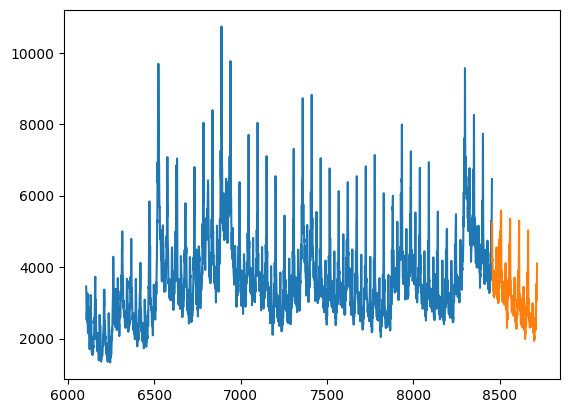

In [24]:
y_train.plot()
y_test.plot()

In [217]:
# Train an XGBoost model
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)
    
# Make predictions
predictions = model.predict(X_test)
    
# Calculate mean absolute percentage error
mape = mean_absolute_percentage_error(y_test, predictions)
    
print(f"Mean Absolute Percentage Error: {mape}")


Mean Absolute Percentage Error: 0.26406032140786667


.fit not scrambling days of data
perform time series cross validation
rolling or expanding in tscv
visualize on train and test for one id
look at prediction for one id same id
plot alligns with numbers then ok to have bad model
symmetrical mape evaluation metric

In [218]:
# Convert predictions to a pandas Series 
predictions_series = pd.Series(predictions, index=y_test.index)

predictions_series

1972    26047.580078
1973    26163.574219
1974    26283.025391
1975    26301.330078
1976    26245.476562
            ...     
2187    26545.406250
2188    26556.792969
2189    26506.927734
2190    26878.958984
2191    26866.648438
Length: 220, dtype: float32

<Axes: >

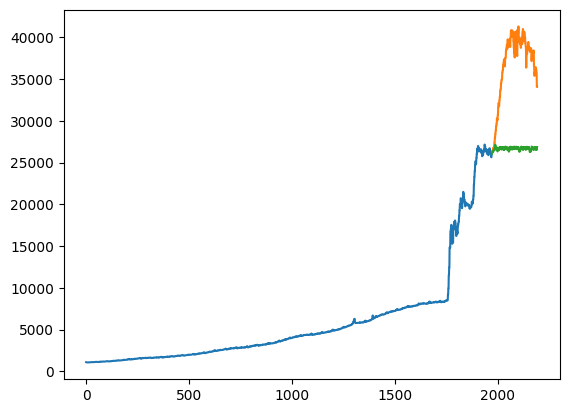

In [219]:
y_train.plot()
y_test.plot()
predictions_series.plot()

# Global model

In [12]:
df_features

,id,timestamp,target,week_of_year,month,week_of_year_sin,week_of_year_cos,month_sin,month_cos,lag_1,...,lag_8,lag_12,lag_26,lag_52,rolling_mean_4,rolling_std_4,rolling_mean_12,rolling_std_12,rolling_mean_52,rolling_std_52
0,0,1975-08-03 12:00:00,1089.2,31,8,-0.568065,-0.822984,-0.866025,-5.000000e-01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1975-08-10 12:00:00,1078.91,32,8,-0.663123,-0.748511,-0.866025,-5.000000e-01,1089.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1975-08-17 12:00:00,1079.88,33,8,-0.748511,-0.663123,-0.866025,-5.000000e-01,1078.91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,1975-08-24 12:00:00,1063.58,34,8,-0.822984,-0.568065,-0.866025,-5.000000e-01,1079.88,...,NaN,NaN,NaN,NaN,1077.8925,10.609629,NaN,NaN,NaN,NaN
4,0,1975-08-31 12:00:00,1060.61,35,8,-0.885456,-0.464723,-0.866025,-5.000000e-01,1063.58,...,NaN,NaN,NaN,NaN,1070.7450,10.069275,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371574,358,2017-09-10 12:00:00,3386.0,36,9,-0.935016,-0.354605,-1.000000,-1.836970e-16,4213.00,...,4458.0,3478.0,2774.0,3166.0,3422.0000,654.312362,3992.083333,750.805441,3496.250000,684.000942
371575,358,2017-09-17 12:00:00,3627.0,37,9,-0.970942,-0.239316,-1.000000,-1.836970e-16,3386.00,...,5098.0,3545.0,2682.0,2774.0,3675.5000,371.873186,3998.916667,746.728557,3512.653846,676.527752
371576,358,2017-09-24 12:00:00,3299.0,38,9,-0.992709,-0.120537,-1.000000,-1.836970e-16,3627.00,...,4518.0,3242.0,2297.0,2932.0,3631.2500,411.901586,4003.666667,741.639993,3519.711538,672.252268
371577,358,2017-10-01 12:00:00,3743.0,39,10,-1.0,-0.0,-0.866025,5.000000e-01,3299.00,...,4973.0,4410.0,2756.0,3218.0,3513.7500,206.412815,3948.083333,733.366764,3529.807692,671.574183


In [13]:
df_features = df_features.sort_values(by=["timestamp"]).reset_index(drop=True)

df_features

,id,timestamp,target,week_of_year,month,week_of_year_sin,week_of_year_cos,month_sin,month_cos,lag_1,...,lag_8,lag_12,lag_26,lag_52,rolling_mean_4,rolling_std_4,rolling_mean_12,rolling_std_12,rolling_mean_52,rolling_std_52
0,38,1890-05-04 12:00:00,1216.0,18,5,0.822984,-0.568065,0.500000,-0.866025,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,39,1890-05-04 12:00:00,1214.5,18,5,0.822984,-0.568065,0.500000,-0.866025,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,43,1890-05-04 12:00:00,1213.0,18,5,0.822984,-0.568065,0.500000,-0.866025,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,39,1890-05-11 12:00:00,1240.0,19,5,0.748511,-0.663123,0.500000,-0.866025,1214.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,38,1890-05-11 12:00:00,1248.0,19,5,0.748511,-0.663123,0.500000,-0.866025,1216.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371574,21,2017-10-15 12:00:00,3460.0,41,10,-0.970942,0.239316,-0.866025,0.500000,3300.0,...,3780.0,2800.0,6190.0,2670.0,3615.0,298.607881,3699.166667,457.988851,3419.230769,667.961036
371575,21,2017-10-22 12:00:00,2760.0,42,10,-0.935016,0.354605,-0.866025,0.500000,3460.0,...,4430.0,3990.0,4490.0,2530.0,3310.0,405.462699,3596.666667,520.372827,3423.653846,662.698076
371576,21,2017-10-29 12:00:00,4730.0,43,10,-0.885456,0.464723,-0.866025,0.500000,2760.0,...,3380.0,3510.0,3900.0,4020.0,3562.5,833.961430,3698.333333,612.859666,3437.307692,682.251507
371577,21,2017-11-05 12:00:00,3930.0,44,11,-0.822984,0.568065,-0.500000,0.866025,4730.0,...,4100.0,4030.0,4270.0,3350.0,3720.0,827.325007,3690.000000,608.604962,3448.461538,685.529378


In [14]:
# Hyperparameter space for RandomizedSearchCV
param_grid = {
    "n_estimators": (50, 200),
    "learning_rate": (0.01, 0.3),
    "max_depth": (4, 6),
}

# Define features and target
X = df_features.drop(columns=["id", "timestamp", "target"])
y = df_features["target"]

# Split into train and test sets (90% train, 10% test)
split_index = int(len(X) * 0.9)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

model = XGBRegressor(random_state=42)
tscv = TimeSeriesSplit(n_splits=3)
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=20,
    scoring="neg_mean_absolute_percentage_error",
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1,
)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = -random_search.best_score_

print(f'Best parameters: {best_params}\n')
print(f'Best score: {best_score}')


Fitting 3 folds for each of 8 candidates, totalling 24 fits


/home/flostyle/miniforge3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.3}

Best score: 0.037164457646725026


In [15]:
global_model = XGBRegressor(**best_params, random_state=42)
global_model.fit(X_train, y_train)

y_pred = global_model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Global Model - MAPE: {mape:.2f}")


Global Model - MAPE: 0.05


In [16]:
# Convert predictions to a pandas Series 
y_pred = pd.Series(y_pred, index=y_test.index)

<Axes: >

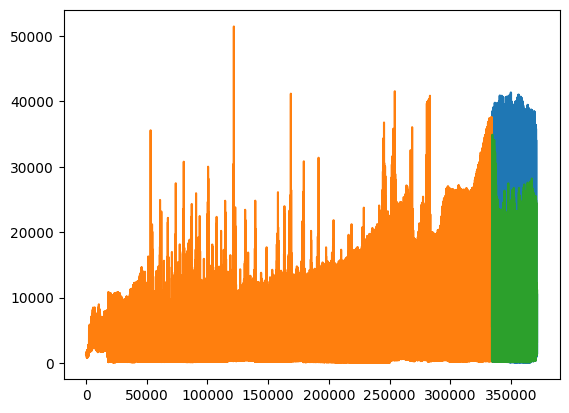

In [17]:
y_test.plot()
y_train.plot()
y_pred.plot()

In [36]:
def calculate_psi(expected, actual, bins=10):
    """
    Calculate Population Stability Index (PSI) between two distributions.
    
    Args:
        expected (array-like): Reference (training) distribution.
        actual (array-like): New (test) distribution.
        bins (int): Number of bins to split the data into.
    
    Returns:
        float: PSI value.
    """
    # Create bins based on expected values
    breakpoints = np.linspace(min(expected), max(expected), bins + 1)
    
    # Calculate the distribution for each dataset
    expected_dist, _ = np.histogram(expected, bins=breakpoints, density=True)
    actual_dist, _ = np.histogram(actual, bins=breakpoints, density=True)
    
    # Replace zero values with a small number to avoid division by zero
    expected_dist = np.where(expected_dist == 0, 1e-1, expected_dist)
    actual_dist = np.where(actual_dist == 0, 1e-1, actual_dist)
    
    # Calculate PSI for each bin
    psi_values = (expected_dist - actual_dist) * np.log(expected_dist / actual_dist)
    return np.sum(psi_values)

# Example usage
# Select a feature to evaluate
psi_results = {}
for feature in X_train.columns:
    train_values = X_train[feature].values
    test_values = X_test[feature].values
    psi = calculate_psi(train_values, test_values, bins=10)
    psi_results[feature] = psi

# Print PSI results for each feature
for feature, psi in psi_results.items():
    print(f"Feature: {feature}, PSI: {psi:.4f}")


Feature: week_of_year, PSI: 0.0023
Feature: month, PSI: 0.0110
Feature: week_of_year_sin, PSI: 0.0254
Feature: week_of_year_cos, PSI: 0.0499
Feature: month_sin, PSI: 0.0267
Feature: month_cos, PSI: 0.0517
Feature: lag_1, PSI: nan
Feature: lag_2, PSI: nan
Feature: lag_4, PSI: nan
Feature: lag_8, PSI: nan
Feature: lag_12, PSI: nan
Feature: lag_26, PSI: nan
Feature: lag_52, PSI: nan
Feature: rolling_mean_4, PSI: nan
Feature: rolling_std_4, PSI: nan
Feature: rolling_mean_12, PSI: nan
Feature: rolling_std_12, PSI: nan
Feature: rolling_mean_52, PSI: nan
Feature: rolling_std_52, PSI: nan


In [37]:
from joblib import dump

# Save the model
dump(global_model, "xgb_model.joblib")

['xgb_model.joblib']

In [38]:
df_features.columns

Index(['id', 'timestamp', 'target', 'week_of_year', 'month',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'lag_1', 'lag_2', 'lag_4', 'lag_8', 'lag_12', 'lag_26', 'lag_52',
       'rolling_mean_4', 'rolling_std_4', 'rolling_mean_12', 'rolling_std_12',
       'rolling_mean_52', 'rolling_std_52'],
      dtype='object')

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from joblib import dump, load
import pandas as pd
import numpy as np
from xgboost import XGBRegressor

def preprocess_data(df):
    # Temporal Features
    df["week_of_year"] = df["timestamp"].dt.isocalendar().week
    df["month"] = df["timestamp"].dt.month

    # Cyclic Features
    df["week_of_year_sin"] = np.sin(2 * np.pi * df["week_of_year"] / 52)
    df["week_of_year_cos"] = np.cos(2 * np.pi * df["week_of_year"] / 52)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

    # Lagged Features
    for lag in [1, 2, 4, 8, 12, 26, 52]:
        df[f"lag_{lag}"] = df["target"].shift(lag)

    # Rolling Features
    df["rolling_mean_4"] = df["target"].rolling(window=4).mean()
    df["rolling_std_4"] = df["target"].rolling(window=4).std()
    df["rolling_mean_12"] = df["target"].rolling(window=12).mean()
    df["rolling_std_12"] = df["target"].rolling(window=12).std()
    df["rolling_mean_52"] = df["target"].rolling(window=52).mean()
    df["rolling_std_52"] = df["target"].rolling(window=52).std()

    # Drop unnecessary columns
    return df.drop(columns=["timestamp", "target"])

# Preprocessing Pipeline
preprocessing_pipeline = Pipeline([
    ("preprocessing", FunctionTransformer(preprocess_data))
])

# Save preprocessing pipeline
dump(preprocessing_pipeline, "preprocessing_pipeline.joblib")


['preprocessing_pipeline.joblib']

In [33]:
# Example usage
df_sample = pd.DataFrame({
    "timestamp": pd.date_range("2023-01-01", periods=10, freq="W"),
    "target": [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
})

# Apply preprocessing
preprocessed_data = preprocessing_pipeline.fit_transform(df_sample)
print(preprocessed_data)

   week_of_year  month  week_of_year_sin  week_of_year_cos  month_sin  \
0            52      1               0.0               1.0   0.500000   
1             1      1          0.120537          0.992709   0.500000   
2             2      1          0.239316          0.970942   0.500000   
3             3      1          0.354605          0.935016   0.500000   
4             4      1          0.464723          0.885456   0.500000   
5             5      2          0.568065          0.822984   0.866025   
6             6      2          0.663123          0.748511   0.866025   
7             7      2          0.748511          0.663123   0.866025   
8             8      2          0.822984          0.568065   0.866025   
9             9      3          0.885456          0.464723   1.000000   

      month_cos  lag_1  lag_2  lag_4  lag_8  lag_12  lag_26  lag_52  \
0  8.660254e-01    NaN    NaN    NaN    NaN     NaN     NaN     NaN   
1  8.660254e-01   10.0    NaN    NaN    NaN     NaN   

In [35]:
# Example usage
df_sample = pd.DataFrame({
    "timestamp": pd.date_range("2023-01-01", periods=10, freq="W"),
    "target": [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
})

In [ ]:
# Load the saved preprocessing pipeline
preprocessing_pipeline = load("preprocessing_pipeline.joblib")

# Preprocess the new data
processed_data = preprocessing_pipeline.transform(df_sample)

# Load the trained model
global_model = load("xgb_model.joblib")

# Make predictions
predictions = global_model.predict(processed_data)
print(f"Predictions: {predictions}")    

Predictions: [2142.308    316.60788  295.08502  199.37836  178.65654  178.65654
  178.65654  178.65654  179.83481  179.10197]
